In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load data
dataset = pd.read_csv('/kaggle/input/beijing-pm25-data-data-set/PRSA_data_2010.1.1-2014.12.31.csv')
df = pd.read_csv('/kaggle/input/beijing-pm25-data-data-set/PRSA_data_2010.1.1-2014.12.31.csv')
df.dropna(inplace=True)

In [3]:
# Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.iloc[:, 5:6].values)

In [4]:
# Prepare the training and testing datasets

lookback = 60  # Number of past time steps to use for prediction

def create_dataset(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, lookback)
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[:int(len(y)*0.8)], y[int(len(y)*0.8):]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [5]:
# Build the LSTM model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
# Train the model

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])


Epoch 1/100
834/834 [==============================] - 23s 14ms/step - loss: 0.0023 - val_loss: 6.0856e-04
Epoch 2/100
834/834 [==============================] - 10s 12ms/step - loss: 0.0010 - val_loss: 4.1178e-04
Epoch 3/100
834/834 [==============================] - 10s 12ms/step - loss: 8.6163e-04 - val_loss: 4.7695e-04
Epoch 4/100
834/834 [==============================] - 11s 13ms/step - loss: 8.1868e-04 - val_loss: 3.8588e-04
Epoch 5/100
834/834 [==============================] - 10s 12ms/step - loss: 8.0103e-04 - val_loss: 4.1025e-04
Epoch 6/100
834/834 [==============================] - 10s 12ms/step - loss: 7.9829e-04 - val_loss: 4.0489e-04
Epoch 7/100
834/834 [==============================] - 10s 12ms/step - loss: 8.1371e-04 - val_loss: 3.9483e-04
Epoch 8/100
834/834 [==============================] - 10s 12ms/step - loss: 7.9746e-04 - val_loss: 4.1711e-04
Epoch 9/100
834/834 [==============================] - 10s 12ms/step - loss: 7.9246e-04 - val_loss: 3.8692e-04


261/261 [==============================] - 2s 5ms/step
Test RMSE: 21.658094999438703


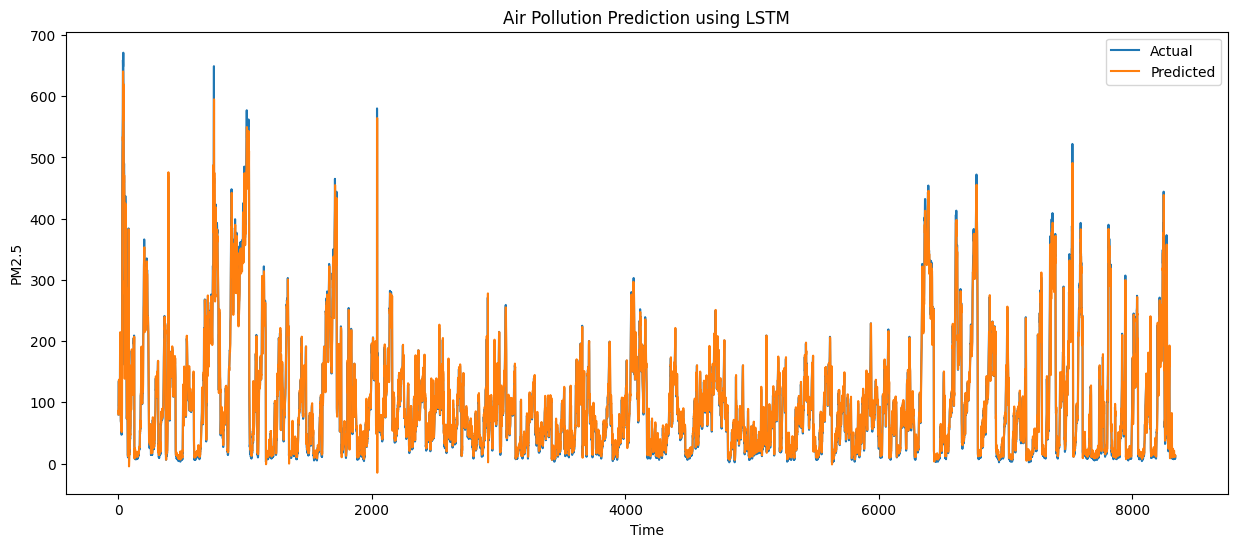

In [7]:
# Predict the PM2.5 values
y_pred = model.predict(X_test)

# Invert the scaling transformation
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Test RMSE:', rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title('Air Pollution Prediction using LSTM')
plt.legend()
plt.show()
